In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
folder_input_path = '/content/drive/My Drive/Colab Notebooks/4_Influencing_Signal/data-hrv-kaggle/'
folder_output_path = '/content/drive/My Drive/Colab Notebooks/4_Influencing_Signal/models/'

In [3]:
# import cudf
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#from cuml.metrics import accuracy_score
#from cuml.neighbors import KNeighborsClassifier
#from cuml.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

In [5]:
%%time
data_train = pd.read_csv(folder_input_path + '/train.csv')
data_test = pd.read_csv(folder_input_path + '/test.csv')

CPU times: user 4.93 s, sys: 323 ms, total: 5.26 s
Wall time: 5.68 s


In [6]:
def run_preprocessing(data, target_column_name='condition', label_encoder=None):
  # Separating the features and the target variable before imputation
  X = data.drop(columns=[target_column_name])  # Features
  y = data[target_column_name]  # Target

  # Imputing missing values in the feature set
  imputer = SimpleImputer(strategy="mean")
  X_imputed = pd.DataFrame(imputer.fit_transform(X.select_dtypes(include=['float64'])),
                          columns=X.select_dtypes(include=['float64']).columns) # include=['float64', 'int64']

  # Standardizing the features
  scaler = StandardScaler()
  X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns)

  # Check if label_encoder is provided, otherwise create a new one
  if label_encoder is None:
      # Encoding the target values
      label_encoder = LabelEncoder()
      # Fitting the encoder to the target values
      label_encoder.fit(y)

  # Transforming the target values to numeric
  y_encoded = label_encoder.transform(y)

  return X_scaled, y_encoded, label_encoder #X_cudf, y_cudf

In [7]:
# Define your feature sets
features = ['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD','HR']

In [8]:
# Splitting the dataset and fit the label encoder on the training data
X_train, y_train, label_encoder = run_preprocessing(data_train)
X_test, y_test, _ = run_preprocessing(data_test, label_encoder=label_encoder)

X_train_sub = X_train[features]
X_test_sub = X_test[features]

In [9]:
from joblib import dump, load

# Save the label_encoder to a file after fitting
dump(label_encoder, folder_output_path + 'label_encoder.joblib')

['/content/drive/My Drive/Colab Notebooks/4_Influencing_Signal/models/label_encoder.joblib']

# KNN

In [10]:
%%time

filename = 'model_knn_fset_2.sav'
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train_sub, y_train).predict(X_test_sub)
pickle.dump(model, open(folder_output_path + filename, 'wb'))

y_pred = model.fit(X_train_sub, y_train).predict(X_test_sub)

report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df

CPU times: user 7.77 s, sys: 430 ms, total: 8.2 s
Wall time: 12.3 s


,precision,recall,f1-score,support
0,0.999660,0.999491,0.999576,11782.000000
1,0.999729,0.999819,0.999774,22158.000000
2,1.000000,1.000000,1.000000,7093.000000
accuracy,0.999756,0.999756,0.999756,0.999756
macro avg,0.999797,0.999770,0.999783,41033.000000
weighted avg,0.999756,0.999756,0.999756,41033.000000


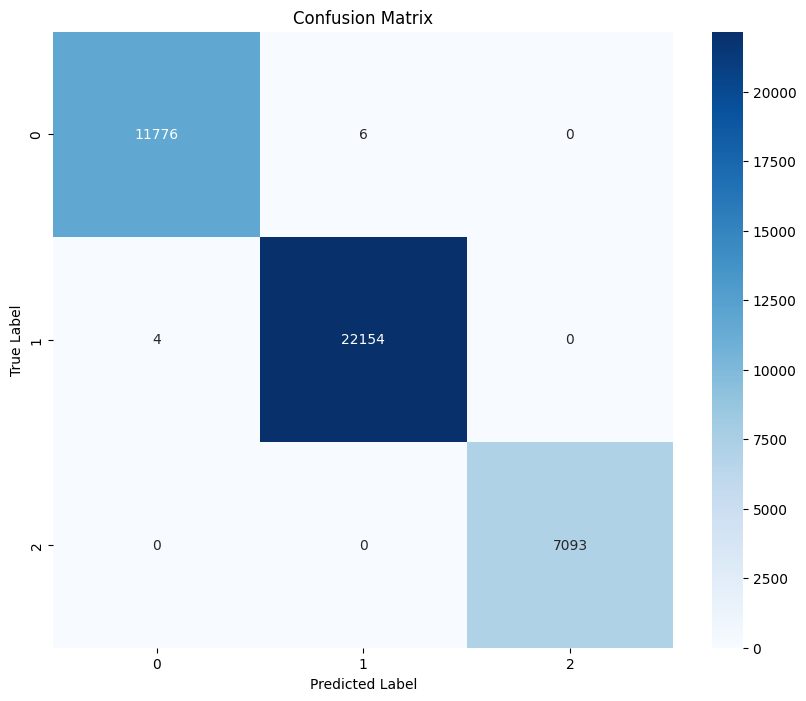

In [11]:
# Creating a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Random Forest

In [12]:
%%time

filename = 'model_rf_fset_2.sav'
model = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=42, n_jobs=-1)
y_pred = model.fit(X_train_sub, y_train).predict(X_test_sub)
pickle.dump(model, open(folder_output_path + filename, 'wb'))

report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df

CPU times: user 3min 7s, sys: 405 ms, total: 3min 7s
Wall time: 1min 50s


,precision,recall,f1-score,support
0,0.997959,0.996181,0.997069,11782.000000
1,0.998285,0.998285,0.998285,22158.000000
2,0.995924,0.998872,0.997396,7093.000000
accuracy,0.997782,0.997782,0.997782,0.997782
macro avg,0.997389,0.997779,0.997583,41033.000000
weighted avg,0.997783,0.997782,0.997782,41033.000000


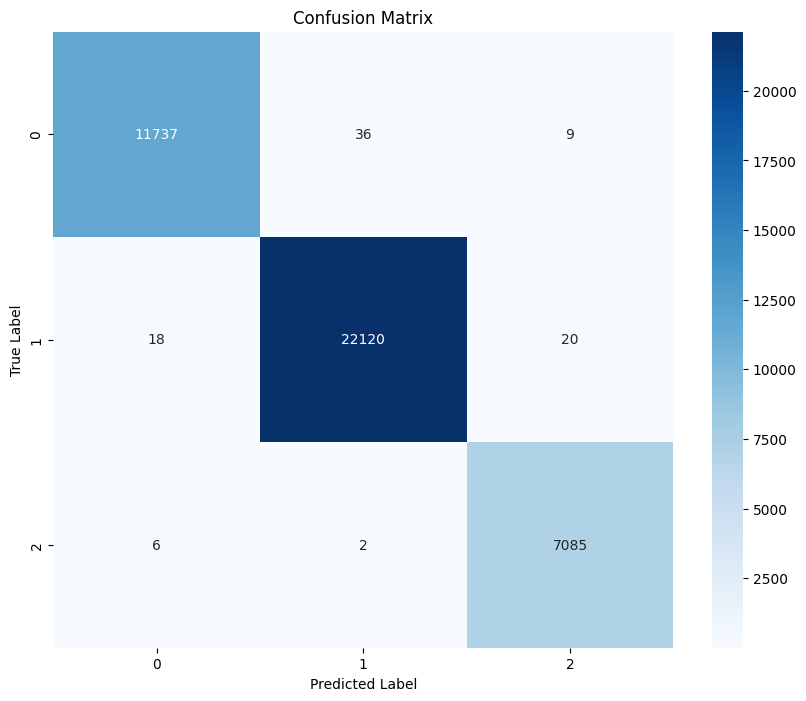

In [13]:
# Creating a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# XGBoost

In [14]:
%%time

filename = 'model_xgb_fset_2.sav'
model = XGBClassifier(tree_method='hist', n_estimators=200, learning_rate=0.2) #, device: 'cuda', random_state=42)
y_pred = model.fit(X_train_sub, y_train).predict(X_test_sub)
pickle.dump(model, open(folder_output_path + filename, 'wb'))

report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df

CPU times: user 43.8 s, sys: 96.5 ms, total: 43.9 s
Wall time: 26 s


,precision,recall,f1-score,support
0,0.987794,0.989051,0.988422,11782.00000
1,0.993861,0.993682,0.993771,22158.00000
2,0.991387,0.989849,0.990617,7093.00000
accuracy,0.991690,0.991690,0.991690,0.99169
macro avg,0.991014,0.990861,0.990937,41033.00000
weighted avg,0.991691,0.991690,0.991690,41033.00000


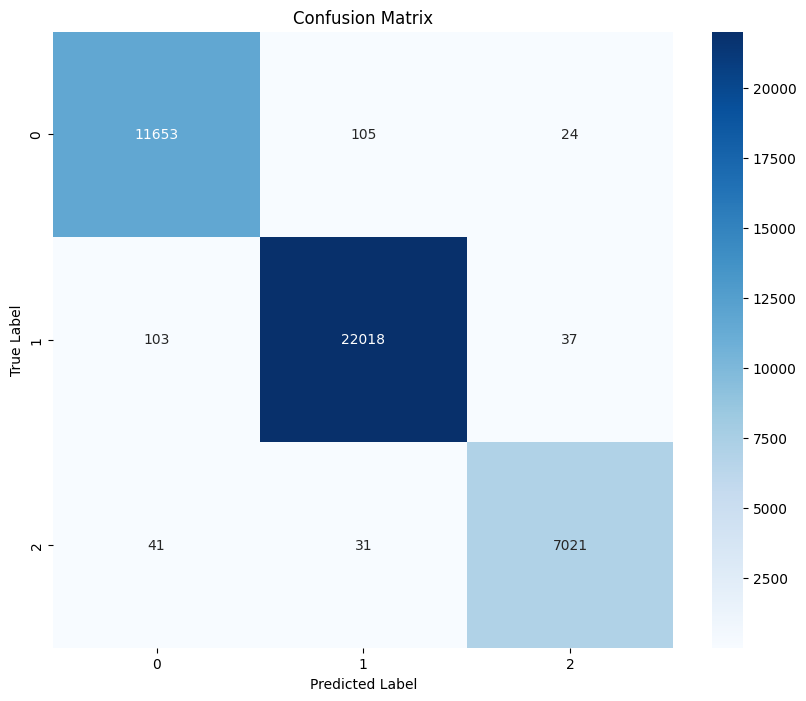

In [15]:
# Creating a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# load the previously saved model from a file
# pickled_cuml_model = pickle.load(open(folder_path + filename, 'rb'))